In [14]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn import cross_validation
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(16, 8)

# Load and adjust the data

In [15]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem.csv', keep_default_na=False)

df_std1.drop([0, 7], axis=0, inplace=True)
df_std1['xlogp'] = df_std1['xlogp'].astype(float)

max_intensity = df_std1['Dil_1_1'].max()
df_std1['Dil_1_1'] = df_std1['Dil_1_1'] / max_intensity
df_std1['Dil_1_1'] = np.log(df_std1['Dil_1_1'])

In [16]:
df_std1.head(5)

,Name,Formula,Adduct,Dil_1_1,InChI,InChI_Key,cid,complexity,exact_mass,h_bond_acceptor_count,h_bond_donor_count,heavy_atom_count,molecular_formula,rotatable_bond_count,tpsa,xlogp
1,Glycerol,C3H8O3,M+H,-7.394659,"InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2",PEDCQBHIVMGVHV-UHFFFAOYSA-N,753,25.2,92.047344,3,3,6,C3H8O3,2,60.7,-1.8
2,Inosine,C10H12N4O5,M+H,-3.916621,InChI=1S/C10H12N4O5/c15-1-4-6(16)7(17)10(19-4)...,UGQMRVRMYYASKQ-KQYNXXCUSA-N,6021,405.0,268.080770,6,4,19,C10H12N4O5,2,129.0,-2.1
3,L-Phenylalanine,C9H11NO2,M+H,-3.105088,InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-...,COLNVLDHVKWLRT-QMMMGPOBSA-N,6140,153.0,165.078979,3,2,12,C9H11NO2,3,63.3,-1.5
4,L-Leucine,C6H13NO2,M+H,-2.883778,"InChI=1S/C6H13NO2/c1-4(2)3-5(7)6(8)9/h4-5H,3,7...",ROHFNLRQFUQHCH-YFKPBYRVSA-N,6106,101.0,131.094629,3,2,9,C6H13NO2,3,63.3,-1.5
5,L-Tryptophan,C11H12N2O2,M+H,-3.517573,InChI=1S/C11H12N2O2/c12-9(11(14)15)5-7-6-13-10...,QIVBCDIJIAJPQS-VIFPVBQESA-N,6305,245.0,204.089878,3,3,15,C11H12N2O2,3,79.1,-1.1


# Data preparation

In [17]:
features = [u'complexity', u'exact_mass', u'h_bond_acceptor_count',
            u'h_bond_donor_count', u'heavy_atom_count',
            u'rotatable_bond_count', u'tpsa', u'xlogp']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_std1, df_std1[['Dil_1_1']], test_size=0.25)

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 46
Number of metabolites (testing): 16


In [18]:
X_train[features].head()

,complexity,exact_mass,h_bond_acceptor_count,h_bond_donor_count,heavy_atom_count,rotatable_bond_count,tpsa,xlogp
62,144.0,152.047344,3,2,11,2,57.5,0.9
42,545.0,354.056195,5,2,25,2,92.2,3.0
20,93.3,119.058243,4,3,8,2,83.6,-2.9
53,531.0,323.051851,8,5,21,4,175.0,-3.4
9,225.0,151.049410,2,3,11,0,96.2,-1.0


# PCA

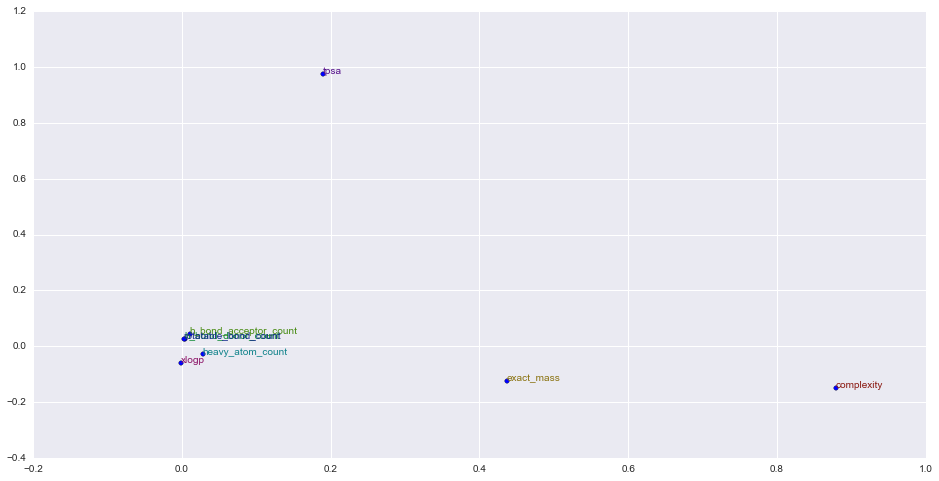

In [19]:
pca = PCA(n_components=3, whiten=True)

pca.fit(X_train[features])

fig, ax = plt.subplots()

plt.scatter(pca.components_[0], pca.components_[1])
colors = sns.hls_palette(len(features), l=.3, s=.8)

for x, y, label, c in zip(pca.components_[0], pca.components_[1], features, colors):
    ann = ax.annotate(label, (x, y), color=c)

plt.grid(True)
plt.show()

In [20]:
# features = [u'complexity', u'tpsa', u'xlogp']

# Fit Gaussian Process

In [21]:
model = GPy.models.GPRegression(X_train[features], y_train)

model.optimize()

In [22]:
from IPython.display import display
display(model)

# Make predictions

We are making predictions on the same data we used for training, which doesn't seem correct

In [23]:
mu, var = model.predict(X_test[features].as_matrix())

In [24]:
data = pd.concat([X_test, DataFrame(mu, columns=['Prediction'], index=X_test.index)], axis=1)

data[['Name', 'Dil_1_1', 'Prediction']]

,Name,Dil_1_1,Prediction
8,L-Methionine,-2.508376,-5.160875
24,beta-Alanine,-4.041766,-5.160875
34,D-Glucosamine,-5.488390,-5.160875
2,Inosine,-3.916621,-5.160875
18,Creatinine,-0.885195,-5.160875
45,Uridine,-7.671607,-5.160875
33,L-Cystine,-7.480022,-5.160875
22,N-Acetyl-D-glucosamine,-4.111983,-5.160875
32,sn-glycero-3-Phosphocholine,-1.413259,-5.160875
43,Phenylhydrazine,-7.440500,-5.160875


# Comparison of model metrics

In [25]:
y_true = data['Dil_1_1']
y_pred_new = data['Prediction']

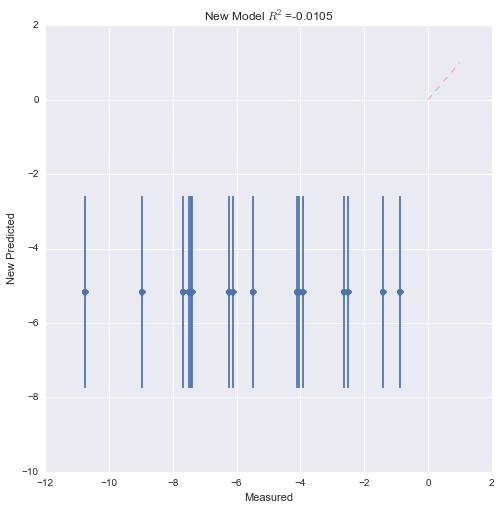

In [26]:
figsize(8, 8)
plt.xlabel('Measured')
plt.ylabel('New Predicted')
plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=np.sqrt(var), fmt='o')
plt.plot([0, 1], [0, 1], 'r--', linewidth=.3)
plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_new)))

plt.show()